In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import chardet


In [2]:


# # Detect the encoding of the CSV file
# with open( "C:\\Users\\mehme\\Desktop\\veriBilimiOdev\\customer_booking.csv", "rb") as f:
#     encoding = chardet.detect(f.read())["encoding"]

# Read the CSV file with the detected encoding
df = pd.read_csv("/home/mehmet/Desktop/yedek/masaüstü/dersler/ödevler/veriBilimiOdev/customer_booking.csv")

# Print the head of the DataFrame
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
def grab_col_names(df, cat_th = 10, car_th = 20):
    cat_cols = [ col for col in df.columns if str(df[col].dtypes) in [ "category", "object","bool"]]
    num_but_cat = [col for col in df.columns if df[col].nunique()  < 10 and df[col].dtypes in ["int64","float64"]]
    cat_but_car = [col for col in df.columns if df[col].nunique() > 20 and str(df[col].dtypes) in ["category","object"]]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes in ["int64","float64"]]
    num_cols = [col for col in df.columns if col not in cat_cols]

    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car


In [4]:
def find_missing_values(df):
  """
  Bu fonksiyon, bir Pandas veri çerçevesindeki tüm sütunlar için eksik değerleri bulur ve yazar.

  Args:
    df (pandas.DataFrame): Eksik değerleri bulunacak veri çerçevesi.

  Returns:
    None: Fonksiyon herhangi bir değer döndürmez, eksik değerleri ekrana basar.
  """

  # Eksik değerlerin sayısını her sütun için hesaplayın
  missing_values = df.isnull().sum()

  # Eksik değerleri olan sütunları filtreleyin
  missing_cols = missing_values[missing_values > 0].index

  # Eksik değerleri olan sütunları ve sayılarını ekrana basın
  if len(missing_cols) > 0:
    print("Eksik Değerlere Sahip Sütunlar:")
    for col in missing_cols:
      print(f"{col}: {missing_values[col]}")
  else:
    print("Veri setinde eksik değer bulunmamaktadır.")

In [5]:
def iqr_outliers(df, column_name, multiplier=1.5,low_th=0.05, up_th = 0.95):
  """
  Bu fonksiyon, bir Pandas veri çerçevesindeki belirli bir sütun için IQR yöntemiyle aykırı değerleri tespit eder.

  Args:
    df (pandas.DataFrame): Veri çerçevesi.
    column_name (str): Aykırı değerleri tespit etmek istediğiniz sütun adı.
    multiplier (float, isteğe bağlı): IQR değerinin çarpılacağı katsayı (varsayılan 1.5).
    low_th(float): Q1 için yüzdelik değeri (varsayılan 0.05)
    up_th(float): Q3 için yüzdelik değeri (varsayılan 0.95)

  Returns:
    pandas.Series: Aykırı değerlerin True/False flaglardan oluşan bir seri.
  """
  low_th = float(low_th)
  up_th = float(up_th)

  data = df[column_name].copy()

  Q1 = data.quantile(low_th)
  Q3 = data.quantile(up_th)

  IQR = Q3 - Q1

  lower_bound = Q1 - (multiplier * IQR)
  upper_bound = Q3 + (multiplier * IQR)
  is_outlier = (data < lower_bound) | (data > upper_bound)

  return is_outlier

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_passengers,50000.0,1.591240,1.020165,1.00,1.00,1.00,2.00,9.0
purchase_lead,50000.0,84.940480,90.451378,0.00,21.00,51.00,115.00,867.0
length_of_stay,50000.0,23.044560,33.887670,0.00,5.00,17.00,28.00,778.0
flight_hour,50000.0,9.066340,5.412660,0.00,5.00,9.00,13.00,23.0
wants_extra_baggage,50000.0,0.668780,0.470657,0.00,0.00,1.00,1.00,1.0
wants_preferred_seat,50000.0,0.296960,0.456923,0.00,0.00,0.00,1.00,1.0
wants_in_flight_meals,50000.0,0.427140,0.494668,0.00,0.00,0.00,1.00,1.0
flight_duration,50000.0,7.277561,1.496863,4.67,5.62,7.57,8.83,9.5
booking_complete,50000.0,0.149560,0.356643,0.00,0.00,0.00,0.00,1.0


## eksik değerler

In [8]:
df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

## sütunlardaki tekil sınıflar

In [9]:
for col in df.columns:
  print(col, ": ", df[col].nunique())

num_passengers :  9
sales_channel :  2
trip_type :  3
purchase_lead :  470
length_of_stay :  335
flight_hour :  24
flight_day :  7
route :  799
booking_origin :  104
wants_extra_baggage :  2
wants_preferred_seat :  2
wants_in_flight_meals :  2
flight_duration :  21
booking_complete :  2


## cat vs num cols
aşağıdaki hücrede tekil değer sayısına göre cat ve num col tespiti yapılmıştır

In [10]:
cat_cols = ["num_passengers", "sales_channel", "trip_type", "flight_day", "route", "booking_origin","wants_extra_baggage","wants_preferred_seat","wants_in_flight_meals","flight_duration"]
num_cols = [col for col in df.columns if col not in cat_cols]
num_cols.remove("booking_complete")

print(cat_cols)
print(num_cols)


['num_passengers', 'sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration']
['purchase_lead', 'length_of_stay', 'flight_hour']


## label encode gerekli sütunlar

In [11]:
def label_encoder(df, categorical_columns):
    le = LabelEncoder()
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col])
    return df

<Figure size 4000x2500 with 0 Axes>

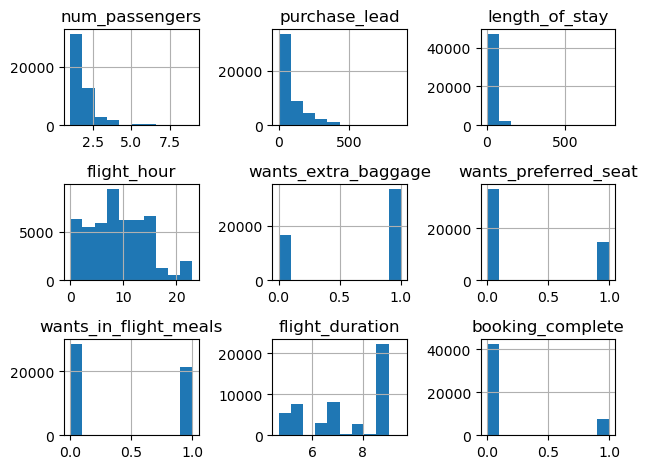

In [12]:
plt.figure(figsize=(40,25))
df.hist()
plt.tight_layout()
plt.show()

## num_passengers

/home/mehmet/Downloads/PREFIX=/home/mehmetokpc/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


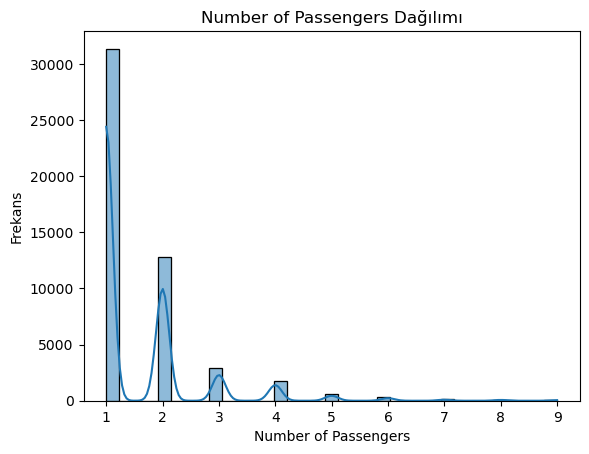

In [13]:
sns.histplot(df["num_passengers"],kde=True,bins = 35)
plt.title("Number of Passengers Dağılımı")
plt.xlabel("Number of Passengers")
plt.ylabel("Frekans")
plt.show()

## sales_channel

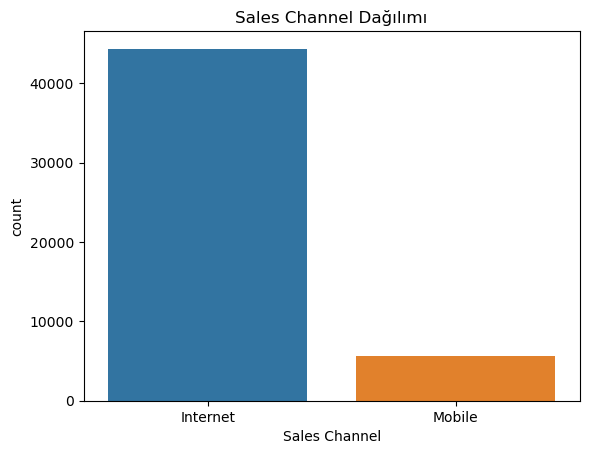

In [14]:
sns.countplot(x="sales_channel", data = df)
plt.title("Sales Channel Dağılımı")
plt.xlabel("Sales Channel")
plt.show()

## purchase_lead

/home/mehmet/Downloads/PREFIX=/home/mehmetokpc/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


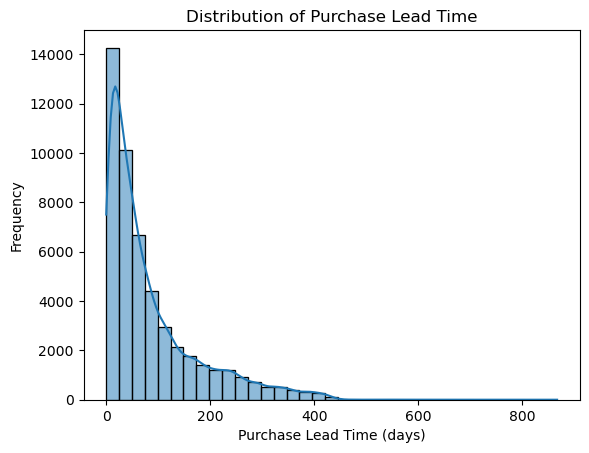

In [15]:
sns.histplot(df['purchase_lead'], bins=35 , kde=True)
plt.title('Distribution of Purchase Lead Time')
plt.xlabel('Purchase Lead Time (days)')
plt.ylabel('Frequency')
plt.show()

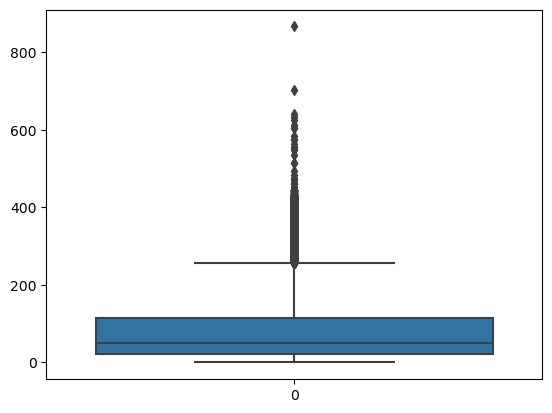

In [26]:
sns.boxplot(df["purchase_lead"])
plt.show()

## flight_duration

/home/mehmet/Downloads/PREFIX=/home/mehmetokpc/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


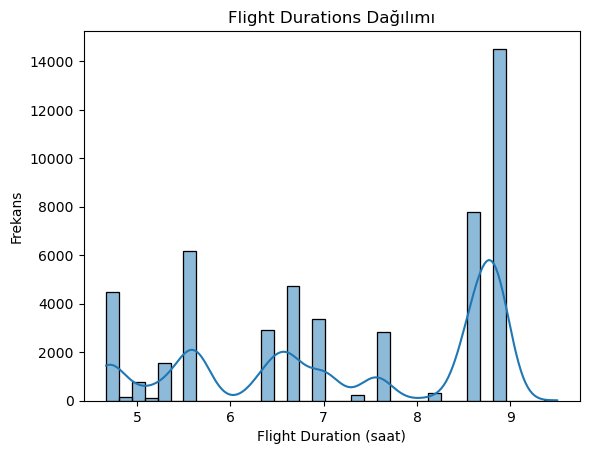

In [16]:
sns.histplot(df["flight_duration"],bins = 35, kde=True)
plt.title('Flight Durations Dağılımı')
plt.xlabel('Flight Duration (saat)')
plt.ylabel('Frekans')
plt.show()

## booking_complete

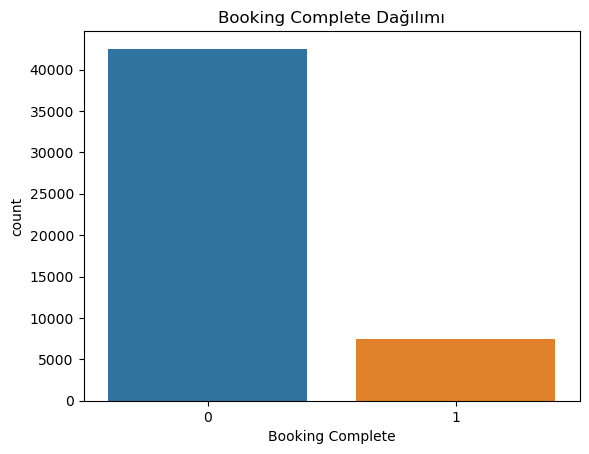

In [17]:
sns.countplot(x="booking_complete", data = df)
plt.title("Booking Complete Dağılımı")
plt.xlabel("Booking Complete")
plt.show()

## trip_type

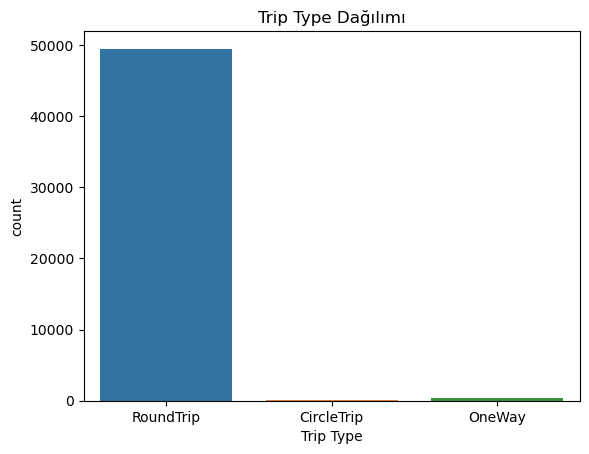

In [23]:
sns.countplot(x="trip_type", data = df)
plt.title("Trip Type Dağılımı")
plt.xlabel("Trip Type")
plt.show()

## booking_origin pie chart

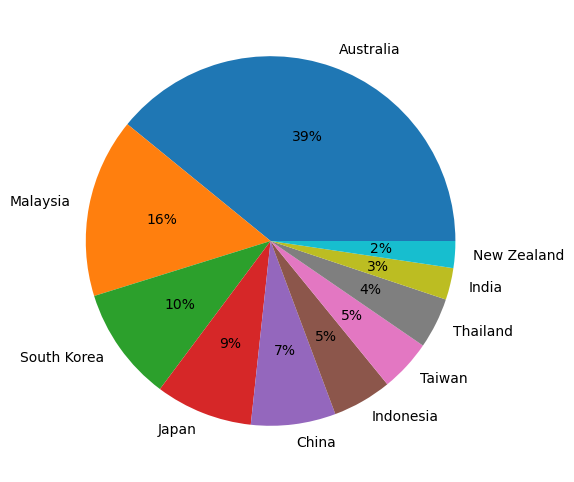

In [21]:
x=df['booking_origin'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(x.head(10),labels=x.head(10).index,autopct='%.0f%%')
plt.show()

## flight_dat pie chart

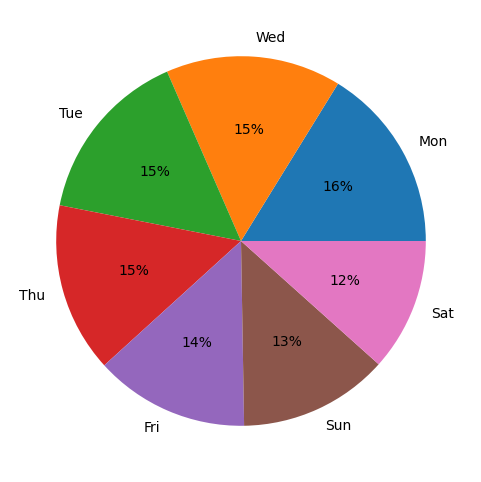

In [22]:
x=df['flight_day'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(x.head(10),labels=x.head(10).index,autopct='%.0f%%')
plt.show()

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_categorical_columns(df, cat_cols):
    n_cols = 2  # Sabit 2 sütunlu
    n_rows = (len(cat_cols) + 1) // n_cols  # Satır sayısını hesapla
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 5 * n_rows))
    
    i, j = 0, 0
    for col in cat_cols:
        ax[i, j].bar(df[col].value_counts().index, df[col].value_counts().values)
        ax[i, j].set_title(col)
        ax[i, j].set_xlabel(str(col))
        ax[i, j].set_ylabel("count")
        j += 1
        if j == n_cols:
            j = 0
            i += 1
            
    plt.tight_layout()
    plt.show()


In [12]:
df_lencoded = label_encoder(df,cat_cols)

In [13]:
df_lencoded.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,1,0,2,262,19,7,2,0,61,1,0,0,8,0
1,0,0,2,112,20,3,2,0,61,0,0,0,8,0
2,1,0,2,243,22,17,6,0,36,1,1,0,8,0
3,0,0,2,96,31,4,2,0,61,0,0,1,8,0
4,1,0,2,68,22,15,6,0,36,1,0,1,8,0


## aykırı değerler

In [15]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols


Observations: 50000
Variables: 14
cat_cols: 5
num_cols: 9
cat_but_car: 0
num_but_cat: 5


['sales_channel',
 'trip_type',
 'purchase_lead',
 'length_of_stay',
 'flight_hour',
 'flight_day',
 'route',
 'booking_origin',
 'flight_duration']

In [16]:
outliers_col = []
for col in num_cols:
  print(col,"sütununda aykırı değer tespit edildi: ",iqr_outliers(df,col).any())
  if iqr_outliers(df,col).any():
    outliers_col.append(col)


print(outliers_col)

sales_channel sütununda aykırı değer tespit edildi:  False
trip_type sütununda aykırı değer tespit edildi:  True
purchase_lead sütununda aykırı değer tespit edildi:  True
length_of_stay sütununda aykırı değer tespit edildi:  True
flight_hour sütununda aykırı değer tespit edildi:  False
flight_day sütununda aykırı değer tespit edildi:  False
route sütununda aykırı değer tespit edildi:  False
booking_origin sütununda aykırı değer tespit edildi:  False
flight_duration sütununda aykırı değer tespit edildi:  False
['trip_type', 'purchase_lead', 'length_of_stay']


In [17]:
for col in num_cols:
  print(col,"sütununda aykırı değer tespit edildi: ",iqr_outliers(df,col).any())

sales_channel sütununda aykırı değer tespit edildi:  False
trip_type sütununda aykırı değer tespit edildi:  True
purchase_lead sütununda aykırı değer tespit edildi:  True
length_of_stay sütununda aykırı değer tespit edildi:  True
flight_hour sütununda aykırı değer tespit edildi:  False
flight_day sütununda aykırı değer tespit edildi:  False
route sütununda aykırı değer tespit edildi:  False
booking_origin sütununda aykırı değer tespit edildi:  False
flight_duration sütununda aykırı değer tespit edildi:  False


In [18]:
def replace_with_mean(df, column_name):
  """
  Bu fonksiyon, bir Pandas veri çerçevesindeki belirli bir sütunun aykırı değerlerini ortalama ile değiştirir.

  Args:
    df (pandas.DataFrame): Veri çerçevesi.
    column_name (str): Aykırı değerleri ortalama ile değiştireceğiniz sütun adı.

  Returns:
    pandas.DataFrame: Aykırı değerleri ortalama ile değiştirilmiş veri çerçevesi.
  """

  # Aykırı değerleri tespit edin
  outliers = iqr_outliers(df, column_name)

  # Ortalamayı hesaplayın
  mean = df[column_name][~outliers].mean()

  # Aykırı değerleri ortalama ile değiştirin
  df.loc[outliers, column_name] = round(mean)

  return df

# Sayısal sütunlarda aykırı değerleri ortalama ile değiştirin
for col in num_cols:
  df = replace_with_mean(df, col)


In [19]:
df = replace_with_mean(df, "length_of_stay")

In [20]:
for col in num_cols:
  print(col,"sütununda aykırı değer tespit edildi: ",iqr_outliers(df,col).any())

sales_channel sütununda aykırı değer tespit edildi:  False
trip_type sütununda aykırı değer tespit edildi:  False
purchase_lead sütununda aykırı değer tespit edildi:  False
length_of_stay sütununda aykırı değer tespit edildi:  False
flight_hour sütununda aykırı değer tespit edildi:  False
flight_day sütununda aykırı değer tespit edildi:  False
route sütununda aykırı değer tespit edildi:  False
booking_origin sütununda aykırı değer tespit edildi:  False
flight_duration sütununda aykırı değer tespit edildi:  False


## korelasyon ısı haritası

c:\Users\mehme\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


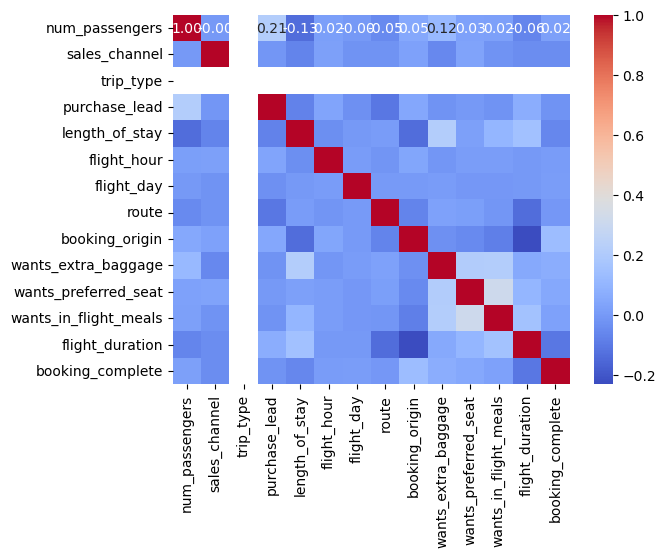

In [21]:


# Create a correlation matrix
corr_matrix = df.corr()

# Generate a heatmap of the correlation matrix
# plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


#bu kod vscodeda bozuk çıktı veriyor colabde düzelecek

Yüksek korelasyonlu özellikler bulunmamaktadır. Drop işlemi uygulamak için herhangi bir özellik tespit edilememiştir.

In [22]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,0,2,262,19,7,2,0,61,1,0,0,5.52,0
1,1,0,2,112,20,3,2,0,61,0,0,0,5.52,0
2,2,0,2,243,22,17,6,0,36,1,1,0,5.52,0
3,1,0,2,96,31,4,2,0,61,0,0,1,5.52,0
4,2,0,2,68,22,15,6,0,36,1,0,1,5.52,0


In [23]:
df_lencoded[outliers_col] = df[outliers_col]

In [24]:
for col in num_cols:
  print(col,"sütununda aykırı değer tespit edildi: ",iqr_outliers(df_lencoded,col).any())

sales_channel sütununda aykırı değer tespit edildi:  False
trip_type sütununda aykırı değer tespit edildi:  False
purchase_lead sütununda aykırı değer tespit edildi:  False
length_of_stay sütununda aykırı değer tespit edildi:  False
flight_hour sütununda aykırı değer tespit edildi:  False
flight_day sütununda aykırı değer tespit edildi:  False
route sütununda aykırı değer tespit edildi:  False
booking_origin sütununda aykırı değer tespit edildi:  False
flight_duration sütununda aykırı değer tespit edildi:  False


## feature engineering

In [25]:
df_lencoded[num_cols].head()

,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,flight_duration
0,0,2,262,19,7,2,0,61,5.52
1,0,2,112,20,3,2,0,61,5.52
2,0,2,243,22,17,6,0,36,5.52
3,0,2,96,31,4,2,0,61,5.52
4,0,2,68,22,15,6,0,36,5.52


In [26]:
"""
   -Bu kısımda sayısal sütunlar çaprazlanarak yeni özellikler türetilmiştir.
   -Modele katkısı fazla olan özellikler elde tutularak gerisi silinecektir.
"""

num_cols_pairs = []
for i in range(len(num_cols)):
  for j in range(i + 1, len(num_cols)):
    num_cols_pairs.append((num_cols[i], num_cols[j]))

for col1, col2 in num_cols_pairs:
  new_col_name = f"{col1}_x_{col2}"
  df_lencoded[new_col_name] = df_lencoded[col1] * df_lencoded[col2]


In [27]:
cat_cols_l, num_cols_l, cat_but_car_l = grab_col_names(df_lencoded)
num_cols_l

Observations: 50000
Variables: 50
cat_cols: 5
num_cols: 45
cat_but_car: 0
num_but_cat: 5


['sales_channel',
 'trip_type',
 'purchase_lead',
 'length_of_stay',
 'flight_hour',
 'flight_day',
 'route',
 'booking_origin',
 'flight_duration',
 'sales_channel_x_trip_type',
 'sales_channel_x_purchase_lead',
 'sales_channel_x_length_of_stay',
 'sales_channel_x_flight_hour',
 'sales_channel_x_flight_day',
 'sales_channel_x_route',
 'sales_channel_x_booking_origin',
 'sales_channel_x_flight_duration',
 'trip_type_x_purchase_lead',
 'trip_type_x_length_of_stay',
 'trip_type_x_flight_hour',
 'trip_type_x_flight_day',
 'trip_type_x_route',
 'trip_type_x_booking_origin',
 'trip_type_x_flight_duration',
 'purchase_lead_x_length_of_stay',
 'purchase_lead_x_flight_hour',
 'purchase_lead_x_flight_day',
 'purchase_lead_x_route',
 'purchase_lead_x_booking_origin',
 'purchase_lead_x_flight_duration',
 'length_of_stay_x_flight_hour',
 'length_of_stay_x_flight_day',
 'length_of_stay_x_route',
 'length_of_stay_x_booking_origin',
 'length_of_stay_x_flight_duration',
 'flight_hour_x_flight_day',
 '

c:\Users\mehme\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


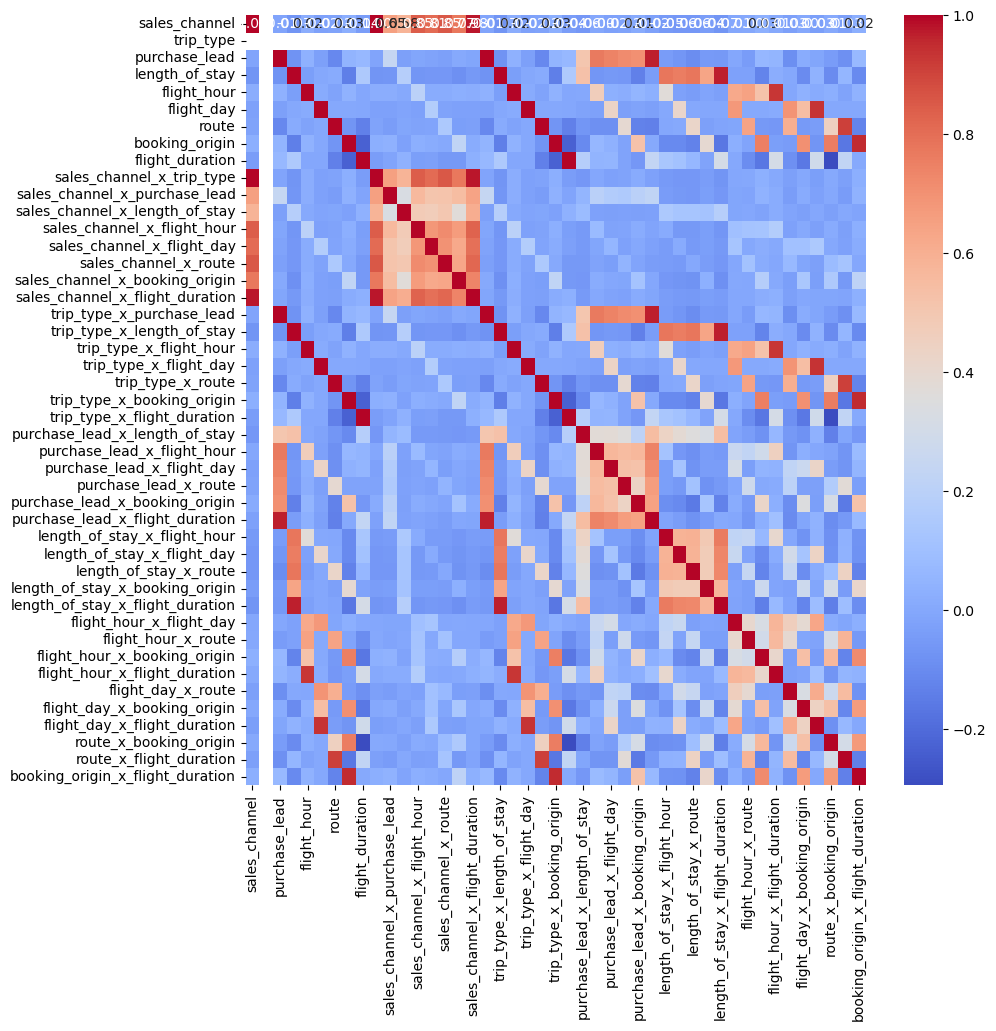

In [28]:
df_lencoded_corr_matrix = df_lencoded[num_cols_l].corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_lencoded_corr_matrix,annot = True, cmap="coolwarm", fmt=".2f")
plt.show()

In [29]:
num_cols_l_new = [col for col in num_cols_l if col not in num_cols]
num_cols_l_new

['sales_channel_x_trip_type',
 'sales_channel_x_purchase_lead',
 'sales_channel_x_length_of_stay',
 'sales_channel_x_flight_hour',
 'sales_channel_x_flight_day',
 'sales_channel_x_route',
 'sales_channel_x_booking_origin',
 'sales_channel_x_flight_duration',
 'trip_type_x_purchase_lead',
 'trip_type_x_length_of_stay',
 'trip_type_x_flight_hour',
 'trip_type_x_flight_day',
 'trip_type_x_route',
 'trip_type_x_booking_origin',
 'trip_type_x_flight_duration',
 'purchase_lead_x_length_of_stay',
 'purchase_lead_x_flight_hour',
 'purchase_lead_x_flight_day',
 'purchase_lead_x_route',
 'purchase_lead_x_booking_origin',
 'purchase_lead_x_flight_duration',
 'length_of_stay_x_flight_hour',
 'length_of_stay_x_flight_day',
 'length_of_stay_x_route',
 'length_of_stay_x_booking_origin',
 'length_of_stay_x_flight_duration',
 'flight_hour_x_flight_day',
 'flight_hour_x_route',
 'flight_hour_x_booking_origin',
 'flight_hour_x_flight_duration',
 'flight_day_x_route',
 'flight_day_x_booking_origin',
 'fli

In [30]:
low_corr_vars_1 = df_lencoded_corr_matrix[abs(df_lencoded_corr_matrix) < 0.05].stack().dropna().index.tolist()
high_corr_vars_1 = df_lencoded_corr_matrix[abs(df_lencoded_corr_matrix) > 0.92].stack().dropna().index.tolist()

In [31]:
high_corr_x_vars = []
for i in high_corr_vars_1:
  if i[0] in num_cols_l_new:
    high_corr_x_vars.append(i[0])
    continue
  if i[1] in num_cols_l_new:
    high_corr_x_vars.append(i[1])
    continue

for col in high_corr_x_vars:
  print(col)

sales_channel_x_trip_type
sales_channel_x_flight_duration
trip_type_x_purchase_lead
purchase_lead_x_flight_duration
trip_type_x_length_of_stay
length_of_stay_x_flight_duration
trip_type_x_flight_hour
flight_hour_x_flight_duration
trip_type_x_flight_day
flight_day_x_flight_duration
trip_type_x_route
trip_type_x_booking_origin
booking_origin_x_flight_duration
trip_type_x_flight_duration
sales_channel_x_trip_type
sales_channel_x_trip_type
sales_channel_x_trip_type
sales_channel_x_purchase_lead
sales_channel_x_length_of_stay
sales_channel_x_flight_hour
sales_channel_x_flight_day
sales_channel_x_route
sales_channel_x_booking_origin
sales_channel_x_flight_duration
sales_channel_x_flight_duration
sales_channel_x_flight_duration
trip_type_x_purchase_lead
trip_type_x_purchase_lead
trip_type_x_purchase_lead
trip_type_x_length_of_stay
trip_type_x_length_of_stay
trip_type_x_length_of_stay
trip_type_x_flight_hour
trip_type_x_flight_hour
trip_type_x_flight_hour
trip_type_x_flight_day
trip_type_x_fli

In [32]:
len(high_corr_x_vars)

76

In [33]:
df_lencoded.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,...,flight_hour_x_flight_day,flight_hour_x_route,flight_hour_x_booking_origin,flight_hour_x_flight_duration,flight_day_x_route,flight_day_x_booking_origin,flight_day_x_flight_duration,route_x_booking_origin,route_x_flight_duration,booking_origin_x_flight_duration
0,2,0,2,262,19,7,2,0,61,1,...,14,0,427,38.64,0,122,11.04,0,0.0,336.72
1,1,0,2,112,20,3,2,0,61,0,...,6,0,183,16.56,0,122,11.04,0,0.0,336.72
2,2,0,2,243,22,17,6,0,36,1,...,102,0,612,93.84,0,216,33.12,0,0.0,198.72
3,1,0,2,96,31,4,2,0,61,0,...,8,0,244,22.08,0,122,11.04,0,0.0,336.72
4,2,0,2,68,22,15,6,0,36,1,...,90,0,540,82.80,0,216,33.12,0,0.0,198.72


In [34]:
df_lencoded.drop(high_corr_x_vars, axis=1, inplace = True)

In [35]:
print(df_lencoded.shape)
df_lencoded.head()

(50000, 14)


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,0,2,262,19,7,2,0,61,1,0,0,5.52,0
1,1,0,2,112,20,3,2,0,61,0,0,0,5.52,0
2,2,0,2,243,22,17,6,0,36,1,1,0,5.52,0
3,1,0,2,96,31,4,2,0,61,0,0,1,5.52,0
4,2,0,2,68,22,15,6,0,36,1,0,1,5.52,0


In [36]:
label_encode_cols

['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']

In [37]:
cat_cols_l2, num_cols_l2, cat_but_car_l2 = grab_col_names(df_lencoded)
remove_list = ["trip_type", "route","booking_origin","sales_channel", "flight_day"]

for i in remove_list:
    num_cols_l2.remove(i)

print(num_cols_l2)

Observations: 50000
Variables: 14
cat_cols: 5
num_cols: 9
cat_but_car: 0
num_but_cat: 5
['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']


c:\Users\mehme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mehme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mehme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mehme\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

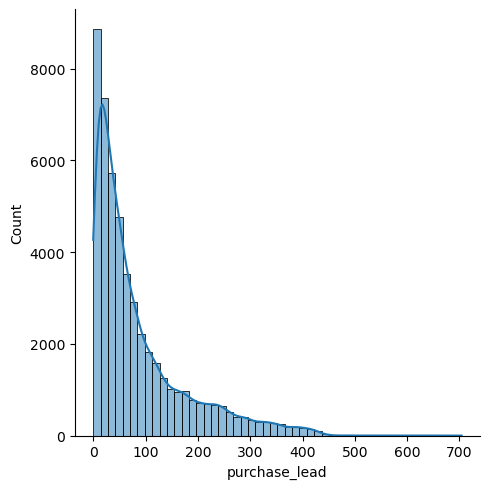

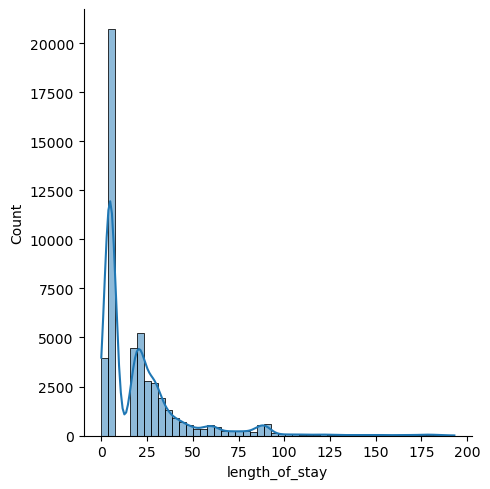

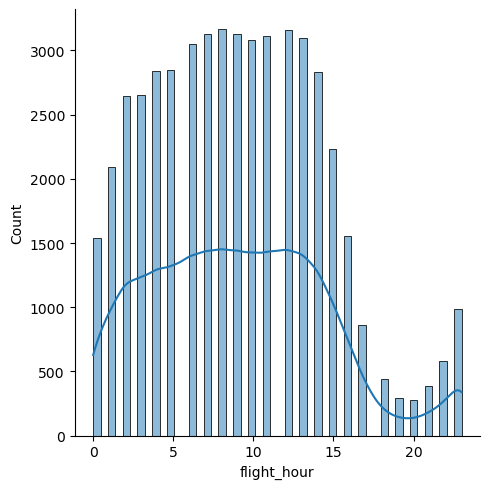

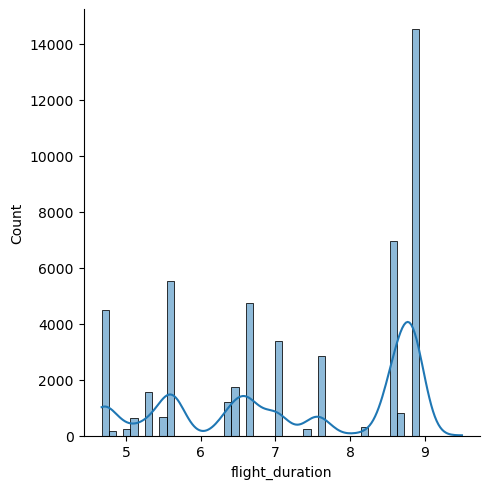

In [38]:
for col in num_cols_l2:
  sns.displot(df_lencoded[col], kde=True, bins = 50, )
plt.show()

## normalizasyon

In [39]:

scaler = MinMaxScaler()
df_lencoded_normalized = df_lencoded.copy()

df_lencoded_normalized = pd.DataFrame(scaler.fit_transform(df_lencoded_normalized), columns=df_lencoded_normalized.columns)

df_lencoded_normalized.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0.125,0.0,0.0,0.372159,0.098446,0.304348,0.333333,0.0,0.592233,1.0,0.0,0.0,0.175983,0.0
1,0.000,0.0,0.0,0.159091,0.103627,0.130435,0.333333,0.0,0.592233,0.0,0.0,0.0,0.175983,0.0
2,0.125,0.0,0.0,0.345170,0.113990,0.739130,1.000000,0.0,0.349515,1.0,1.0,0.0,0.175983,0.0
3,0.000,0.0,0.0,0.136364,0.160622,0.173913,0.333333,0.0,0.592233,0.0,0.0,1.0,0.175983,0.0
4,0.125,0.0,0.0,0.096591,0.113990,0.652174,1.000000,0.0,0.349515,1.0,0.0,1.0,0.175983,0.0


In [41]:


X = df_lencoded_normalized.drop("booking_complete", axis = 1)
y = df_lencoded_normalized["booking_complete"]

# X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

model_svr = SVR(kernel="sigmoid", C = 0.1, epsilon = 0.2)
model_svr.fit(X,y)

SVR(C=0.1, epsilon=0.2, kernel='sigmoid')

In [42]:
from sklearn.model_selection import KFold

kf_params ={
    "n_splits": 10, 
    "shuffle": True, 
    "random_state": 42
}

kf = KFold(n_splits= 10, shuffle= True, random_state= 42)

In [43]:
print(kf)

KFold(n_splits=10, random_state=42, shuffle=True)


In [50]:
from sklearn.model_selection import cross_val_score

mse_scores = cross_val_score(model_svr,X,y,cv = kf, scoring="neg_mean_squared_error")
mse_scores = -mse_scores

In [51]:
print("K-fold Cross-Validation MSE Scores:")
print(mse_scores)
print("Mean MSE:", mse_scores.mean())

K-fold Cross-Validation MSE Scores:
[2696.38452533 2681.99158359 2603.75078081 2626.55523521 2657.76273253
 2631.89078286 2653.97814116 2716.31676753 2688.02822002 2612.90662875]
Mean MSE: 2656.956539778614


In [ ]:
model_svr.score(X,y)

In [ ]:
print("K-fold Cross-Validation MSE Scores:")
print(mse_scores)
print("Mean MSE:", mse_scores.mean())

In [49]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [ ]:


with open("model_svr.pk1", "wb") as f:
    pickle.dump(model_svr,f)

    import pickle

# Modeli dosyadan yükleyin
# with open('svr_model.pkl', 'rb') as f:
#     model = pickle.load(f)



In [ ]:
model = SVR()
# with open('C:\Users\mehme\Desktop\veriBilimiOdev\model_svr.pk1', 'rb') as f:

    model = pickle.load(open("C:\Users\mehme\Desktop\veriBilimiOdev\model_svr.pk1"))

IndentationError: unexpected indent (4171162501.py, line 4)

In [ ]:
import joblib
model = joblib.load("model_svr.pk1")

In [ ]:
model.get_params()

{'C': 0.1,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.2,
 'gamma': 'scale',
 'kernel': 'sigmoid',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
model.score(X_test,y_test)

NameError: name 'X_test' is not defined